In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from metrics.var import calculate_garch, calculate_historical
from parsing.bonds import Bond, __SELECTED__BONDS__
from parsing.commodities import Brent
from parsing.currencies import Currency, __SELECTED__CURRENCIES__
from parsing.indexes import Index, __SELECTED_INDEXES__
from parsing.portfolio import Portfolio, SecurityGroup
from parsing.stocks import Stock, __SELECTED_STOCKS__
from parsing.zero_coupon import ZeroCoupon

plt.rcParams.update({'font.size': 14, 'figure.figsize': (12, 8)})

In [2]:
np.random.seed(42)

## Зададим факторы риска

Используем следующие риск-факторы:

1) Фьючерсы на нефть марки Brent с 1, 2 и 3 месяцами до погашения
2) Валютные пары USD/RUB, EUR/RUB, CNY/RUB
3) Индексы IMOEX и RTSI
4) Процентные ставки за 0-30 лет

In [3]:
brent = [Brent(period=period) for period in (1, 2, 3)] # 1
currencies = [Currency(curr) for curr in __SELECTED__CURRENCIES__] # 2
indexes = [Index(idx) for idx in __SELECTED_INDEXES__] # 3
rates = ZeroCoupon() # 4

## Зададим группы инструментов

Инструменты делятся в портфеле по классу, для того чтобы считать их зависимость от факторов рисков по группам.
Выделим следующие группы:

1) Акции. 10 акций из списка голубых фишек
2) Облигации. 5 облигаций ОФЗ с фиксированным доходом
3) Валюты. 3 валюты: Доллар, Евро и Китайский юань

Также зададим следующую зависимость между факторыми:

1) Акции ~ Фьючерсы на нефть + Курсы валют + Индексы акций
2) Облигации ~ Фьючерсы на нефть + Процентные ставки
3) Валюты ~ Курсы валют

In [4]:
stocks = [Stock(st) for st in __SELECTED_STOCKS__]
bonds = [Bond(b) for b in __SELECTED__BONDS__]

In [5]:
stock_group = SecurityGroup(name='Акции', securities=stocks, factors=brent + currencies + indexes, n_components=6) # 1
currency_group = SecurityGroup(name='Валюта', securities=currencies, factors=currencies, n_components=1) # 2
bonds_group = SecurityGroup(name='Облигации', securities=bonds, factors=brent + [rates], n_components=6) # 3

/Users/germanarutunov/Projects/ftiad/market-risk/parsing/commodities.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  concatenated = concatenated.append(filtered.to_pandas())
/Users/germanarutunov/Projects/ftiad/market-risk/parsing/commodities.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  concatenated = concatenated.append(filtered.to_pandas())
/Users/germanarutunov/Projects/ftiad/market-risk/parsing/commodities.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  concatenated = concatenated.append(filtered.to_pandas())
/Users/germanarutunov/Projects/ftiad/market-risk/parsing/commodities.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

In [6]:
portfolio = Portfolio(name='Факторный портфель', periods=1, factors=brent + currencies + indexes + [rates], securities=[stock_group, currency_group, bonds_group])

## Обучение

В процессе обучения происходят следующие вещи:
1) Методом главных компонент выделяются новые риск факторы
2) Подбираются параметры для факторов риска

In [7]:
portfolio.fit()

  0%|          | 0/3 [00:00<?, ?it/s]

                            OLS Regression Results                            
Dep. Variable:             stock_ALRS   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     76.28
Date:                Mon, 25 Apr 2022   Prob (F-statistic):           7.58e-82
Time:                        19:33:06   Log-Likelihood:                 3609.0
No. Observations:                1322   AIC:                            -7204.
Df Residuals:                    1315   BIC:                            -7168.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.000      1.187      0.2

## Value-at-Risk

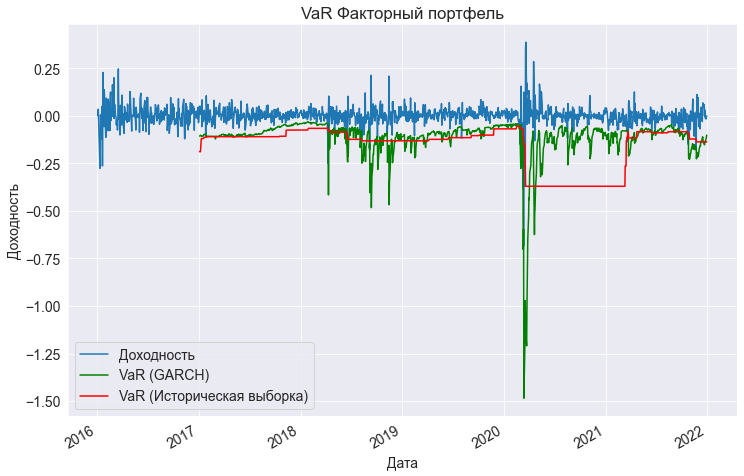

In [8]:
portfolio.plot_returns()
GARCH_VaR = portfolio.plot_value_at_risk(calc_func=calculate_garch, plot_kwargs=dict(var_title='VaR (GARCH)', color='g'))
HS_VaR = portfolio.plot_value_at_risk(calc_func=calculate_historical, plot_kwargs=dict(var_title='VaR (Историческая выборка)', color='r'))
plt.savefig('VaR.png')
plt.show()

## Expected Shortfall

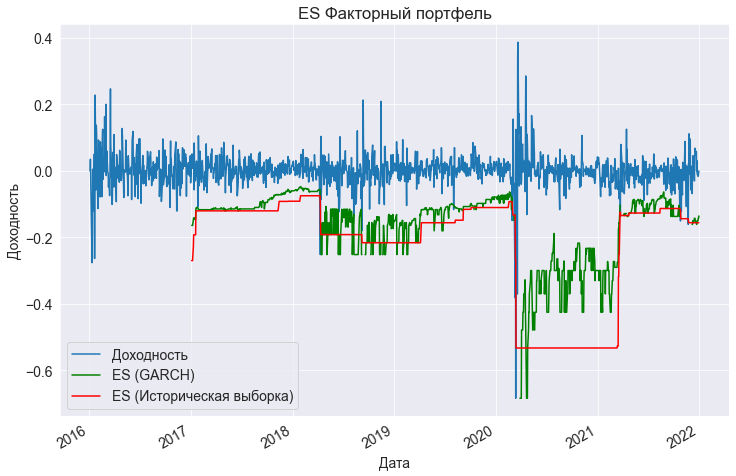

In [9]:
portfolio.plot_returns()
GARCH_ES = portfolio.plot_expected_shortfall(calc_func=calculate_garch, plot_kwargs=dict(es_title='ES (GARCH)', color='g'))
HS_ES = portfolio.plot_expected_shortfall(calc_func=calculate_historical, plot_kwargs=dict(es_title='ES (Историческая выборка)', color='r'))
plt.savefig('ES.png')
plt.show()

## Backtesting

### VaR (GARCH)

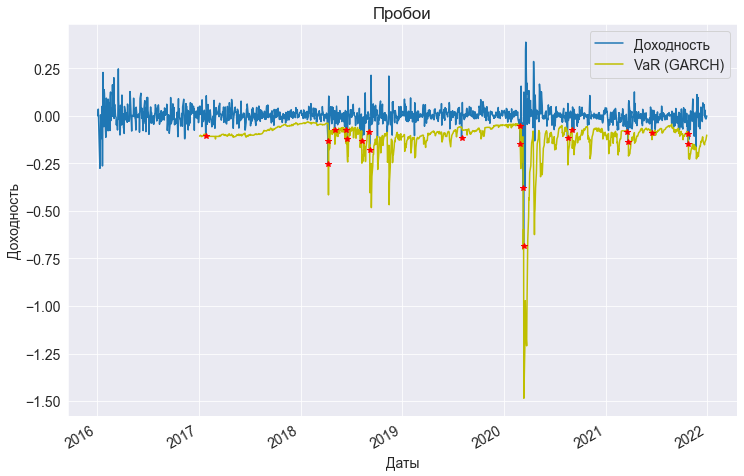

,Значение
Показатель,
"Доля пробоев, %",1.39
"P-value (greater), %",8.83
Зона светофора,Зеленая


In [10]:
results_GARCH_VaR = portfolio.backtest(metric=GARCH_VaR, metric_label='VaR (GARCH)')
plt.savefig('hits_GARCH_VaR.png')
plt.show()

results_GARCH_VaR

### VaR (Историческая выборка)

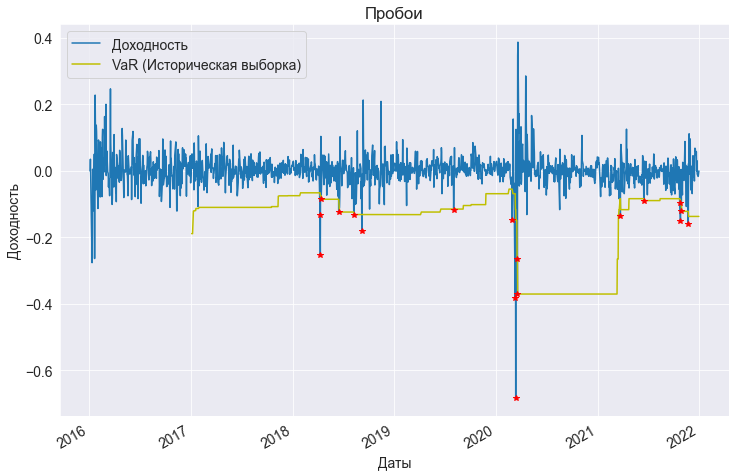

,Значение
Показатель,
"Доля пробоев, %",1.19
"P-value (greater), %",26.32
Зона светофора,Зеленая


In [11]:
results_HS_VaR = portfolio.backtest(metric=HS_VaR, metric_label='VaR (Историческая выборка)')
plt.savefig('hits_HS_VaR.png')
plt.show()
results_HS_VaR

### ES (GARCH)

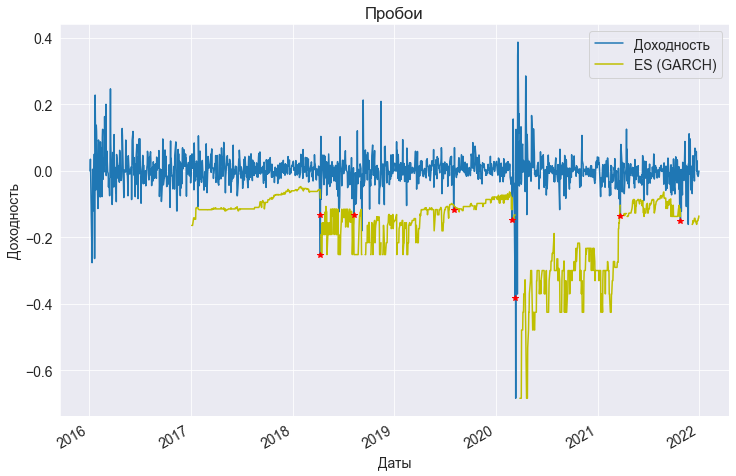

,Значение
Показатель,
"Доля пробоев, %",0.53
"P-value (greater), %",98.39
Зона светофора,Зеленая


In [12]:
results_GARCH_ES = portfolio.backtest(metric=(-GARCH_ES), metric_label='ES (GARCH)')
plt.savefig('hits_GARCH_ES.png')
plt.show()
results_GARCH_ES

### ES (Историческая выборка)

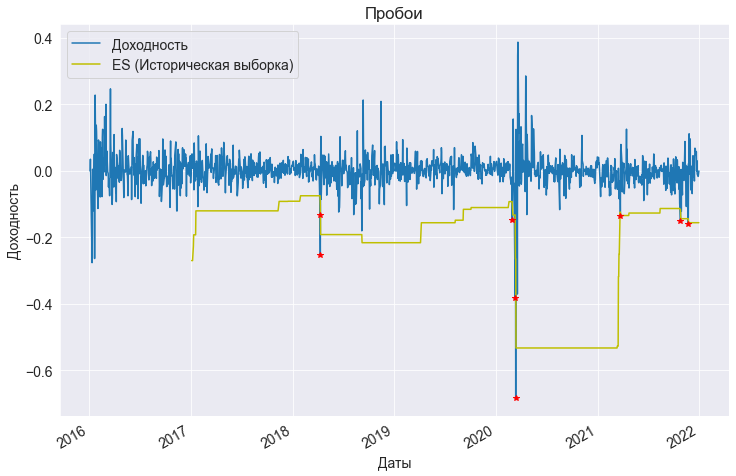

,Значение
Показатель,
"Доля пробоев, %",0.53
"P-value (greater), %",98.39
Зона светофора,Зеленая


In [13]:
results_HS_ES = portfolio.backtest(metric=(-HS_ES), metric_label='ES (Историческая выборка)')
plt.savefig('hits_HS_ES.png')
plt.show()
results_HS_ES

### Акции

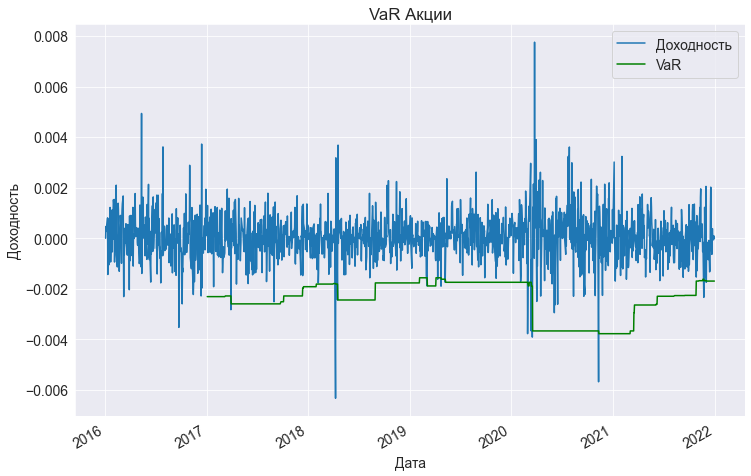

In [14]:
stock_group.plot_returns()
stocks_HS_VaR = stock_group.plot_value_at_risk(calc_func=calculate_historical, plot_kwargs=dict(color='g'))
plt.savefig('stock_group_ES_VaR.png')
plt.show()

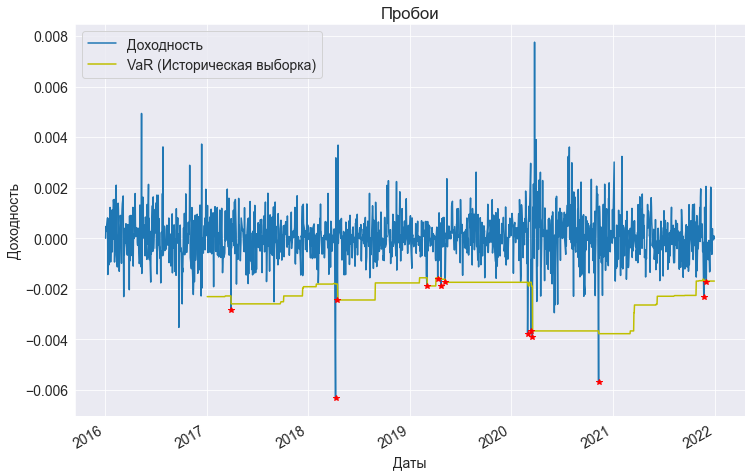

,Значение
Показатель,
"Доля пробоев, %",0.86
"P-value (greater), %",74.59
Зона светофора,Зеленая


In [15]:
results_stock_group_HS_VaR = stock_group.backtest(metric=stocks_HS_VaR, metric_label='VaR (Историческая выборка)')
plt.savefig('hits_stock_group_HS_VaR.png')
plt.show()
results_stock_group_HS_VaR

### Облигации

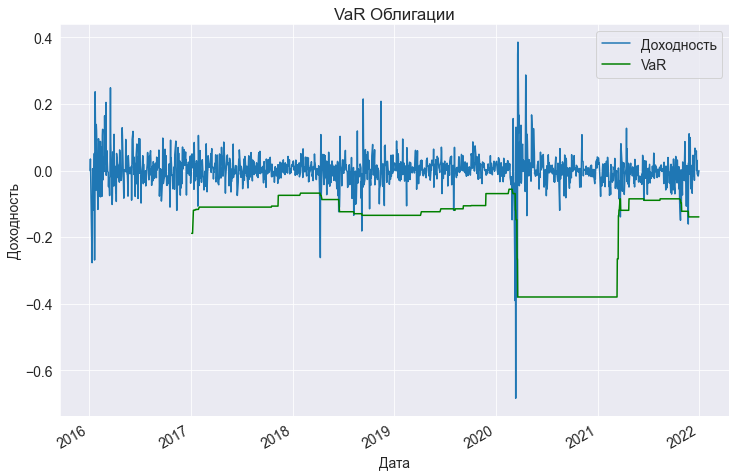

In [16]:
bonds_group.plot_returns()
bonds_HS_VaR = bonds_group.plot_value_at_risk(calc_func=calculate_historical, plot_kwargs=dict(color='g'))
plt.savefig('bonds_ES_VaR.png')
plt.show()

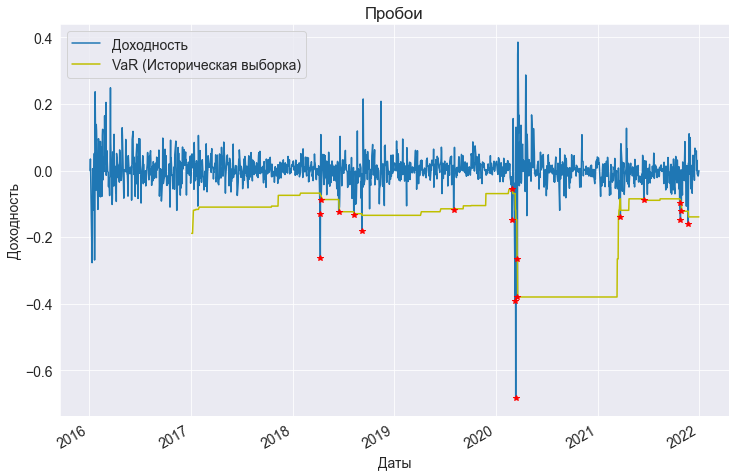

,Значение
Показатель,
"Доля пробоев, %",1.25
"P-value (greater), %",19.02
Зона светофора,Зеленая


In [17]:
results_bonds_HS_VaR = bonds_group.backtest(metric=bonds_HS_VaR, metric_label='VaR (Историческая выборка)')
plt.savefig('hits_bonds_HS_VaR.png')
plt.show()
results_bonds_HS_VaR

### Валюты

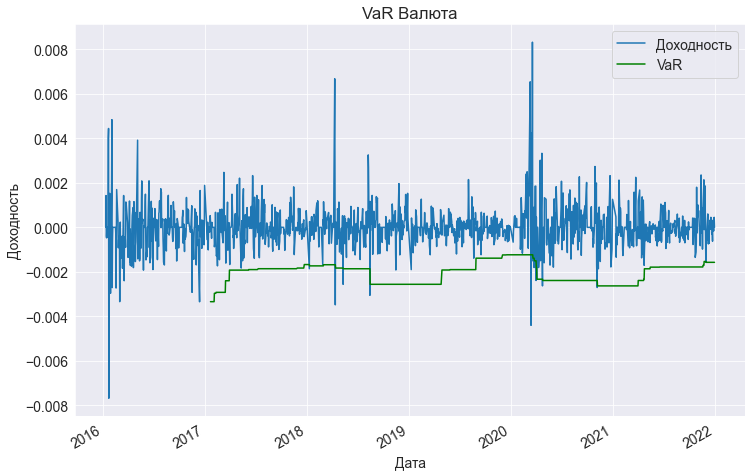

In [18]:
currency_group.plot_returns()
currency_HS_VaR = currency_group.plot_value_at_risk(calc_func=calculate_historical, plot_kwargs=dict(color='g'))
plt.savefig('currency_ES_VaR.png')
plt.show()

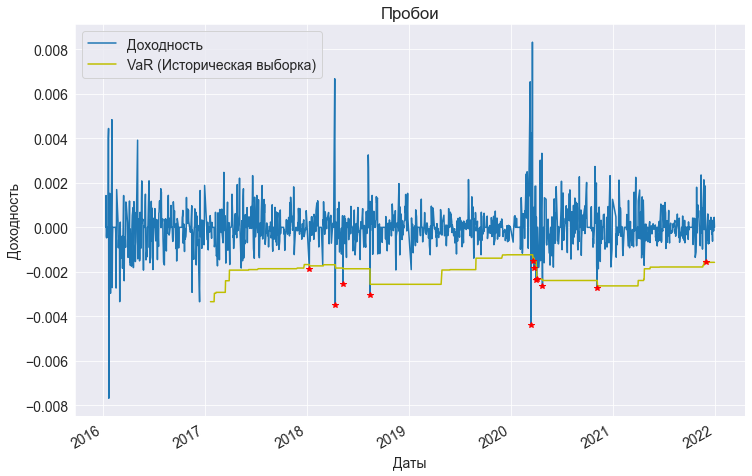

,Значение
Показатель,
"Доля пробоев, %",1.25
"P-value (greater), %",19.02
Зона светофора,Зеленая


In [19]:
results_currency_HS_VaR = currency_group.backtest(metric=currency_HS_VaR, metric_label='VaR (Историческая выборка)')
plt.savefig('hits_currency_HS_VaR.png')
plt.show()
results_bonds_HS_VaR